In [1]:
%matplotlib inline

In [154]:
from pathlib import Path
import re
import matplotlib.pyplot as plt
from matplotlib import pyplot
import eelbrain
import mne
from eelbrain import *
#import trftools
from eelbrain import testnd

from pprint import pprint
import numpy as np
from scipy import stats
import pandas as pd
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests

In [3]:
## Load in ESLs data ##

#STIMULI = [str(i) for i in range(1, 13)]
#DATA_ROOT = Path("/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results")  #Path("~").expanduser() / 'Data' / 'Alice'
DATA_ROOT = Path("/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results")
#PREDICTOR_audio_DIR = DATA_ROOT / 'TRFs_pridictors/audio_predictors'
#PREDICTOR_word_DIR = DATA_ROOT / 'TRFs_pridictors/word_predictors'
EEG_DIR = DATA_ROOT / 'EEG_ESLs' / 'Alice_ESL_ICAed_fif'
IMF_DIR = DATA_ROOT/ "TRFs_pridictors/IF_predictors"
F0_DIR = DATA_ROOT/ "TRFs_pridictors/F0_predictors"
IMFsLIST = [path.name for path in IMF_DIR.iterdir() if re.match(r'Alice_IF_IMF_*', path.name)] 
ESL_SUBJECTS = [path.name for path in EEG_DIR.iterdir() if re.match(r'n_2_S\d*', path.name)]  #S01_alice-raw.fif

# Define a target directory for TRF estimates and make sure the directory is created
TRF_DIR = DATA_ROOT / 'TRFs_ESLs'
TRF_DIR.mkdir(exist_ok=True)
print(ESL_SUBJECTS)
print(len(ESL_SUBJECTS))  # 26
DST = TRF_DIR / 'ESLs_figures'
DST.mkdir(exist_ok=True)

['n_2_S030_ICAed_raw.fif', 'n_2_S027_ICAed_raw.fif', 'n_2_S023_ICAed_raw.fif', 'n_2_S034_ICAed_raw.fif', 'n_2_S024_ICAed_raw.fif', 'n_2_S019_ICAed_raw.fif', 'n_2_S020_ICAed_raw.fif', 'n_2_S013_ICAed_raw.fif', 'n_2_S017_ICAed_raw.fif', 'n_2_S039_ICAed_raw.fif', 'n_2_S010_ICAed_raw.fif', 'n_2_S029_ICAed_raw.fif', 'n_2_S015_ICAed_raw.fif', 'n_2_S028_ICAed_raw.fif', 'n_2_S011_ICAed_raw.fif', 'n_2_S038_ICAed_raw.fif', 'n_2_S016_ICAed_raw.fif', 'n_2_S012_ICAed_raw.fif', 'n_2_S021_ICAed_raw.fif', 'n_2_S036_ICAed_raw.fif', 'n_2_S032_ICAed_raw.fif', 'n_2_S025_ICAed_raw.fif', 'n_2_S035_ICAed_raw.fif', 'n_2_S022_ICAed_raw.fif', 'n_2_S026_ICAed_raw.fif', 'n_2_S031_ICAed_raw.fif']
26


In [4]:
## VST score of each sub ##
VST_Score_STR_LIST = ['6.7', '7.3', '7.8', '8.2', '8.4', '6.4', '7.5', '6.7', '5.2', '5.3', '6.5'
                 , '5.1', '6.1', '7.9', '8.7', '8.0', '8.8', '6.4', '7.0', '7.4', '6.6', '7.2'
                 , '7.0', '7.3', '7.3', '7.7']  # 26 subs
VST_Score_float_LIST = [6.7, 7.3, 7.8, 8.2, 8.4, 6.4, 7.5, 6.7
                        , 5.2, 5.3, 6.5, 5.1, 6.1, 7.9, 8.7, 8.0
                        , 8.8, 6.4, 7.0, 7.4, 6.6, 7.2, 7.0, 7.3, 7.3, 7.7]
# exclude sub: 14 / 18 / 33 / 37
sub_idLIST = [10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27
              , 28, 29, 30, 31, 32, 34, 35, 36, 38, 39]
# Female = 1; Male = 2
sub_SexLIST = ["F", "M", "M", "F", "F", "M", "F", "M", "M", "F", "M", "F", "F", "M", "F", "M", "F", "M", "F", "M", "F", "M", "F", "M", "F", "M"]
 
# dictionary of lists 
VST_df = pd.DataFrame({'id': sub_idLIST, 'VST': VST_Score_float_LIST, 'gender':sub_SexLIST})
   
#VST_df = pd.DataFrame(id_VST_DICT)
   
#print(VST_df) 
#print(type(VST_df["VST"][0]))
print(VST_df.loc[0])

id         10
VST       6.7
gender      F
Name: 0, dtype: object


In [5]:
## GET the VST score according to the sub_id ##
for subject in ESL_SUBJECTS:
    #print(type(subject[4:8]))
    #print(subject[6:8])
    #print(int(subject[6:8]), ">>>", VST_df.loc[VST_df["id"]==int(subject[6:8])])
    #print(int(subject[6:8]), ">>>", VST_df.loc[VST_df["id"]==int(subject[6:8])]["VST"])

    VST_scoreFLOAT = float(round(VST_df.loc[VST_df["id"]==int(subject[6:8])]["VST"]), 0
    
    print("SUB", subject[6:8], "VST score = ", VST_scoreFLOAT)

SUB 30 VST score =  7.0
SUB 27 VST score =  8.0
SUB 23 VST score =  5.1
SUB 34 VST score =  7.2
SUB 24 VST score =  6.1
SUB 19 VST score =  6.7
SUB 20 VST score =  5.2
SUB 13 VST score =  8.2
SUB 17 VST score =  7.5
SUB 39 VST score =  7.7
SUB 10 VST score =  6.7
SUB 29 VST score =  6.4
SUB 15 VST score =  8.4
SUB 28 VST score =  8.8
SUB 11 VST score =  7.3
SUB 38 VST score =  7.3
SUB 16 VST score =  6.4
SUB 12 VST score =  7.8
SUB 21 VST score =  5.3
SUB 36 VST score =  7.3
SUB 32 VST score =  6.6
SUB 25 VST score =  7.9
SUB 35 VST score =  7.0
SUB 22 VST score =  6.5
SUB 26 VST score =  8.7
SUB 31 VST score =  7.4


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_60080/1783920786.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  VST_scoreFLOAT = float(VST_df.loc[VST_df["id"]==int(subject[6:8])]["VST"])


In [6]:
## Import the model of F0 & Envelope & Onset TRF of ESLs ##
# Compare the TRFs corresponding to F0 and Envelopes.

# Build the model_data['model']
models = ['Fzero', 'Fzero+envelope', 'Fzero+envelope+env_onset'] # Change the description
rows = []
for model in models:
    print(model)
    for subject in ESL_SUBJECTS:
        trf = eelbrain.load.unpickle(TRF_DIR / subject[4:8] / f'{subject[4:8]} {model}.pickle')
        #print(trf)
        trf.x = ['f0', 'f0env', 'f0envenvon'] #rename the model (no punctuation)
        #rows.append([n_subj, model, *trf.h_scaled])
        rows.append([subject, model, trf.proportion_explained])

model_data = eelbrain.Dataset.from_caselist(['subject', 'model', 'det'], rows)
#pprint(rows)
print(model_data)

# For more interpretable numbers, express proportion explained in terms of the maximum explained variability of the most complete model
index = model_data['model'] == 'IMFAll'
model_data['det'] *= 100 / model_data[index, 'det'].mean('case').max('sensor')
# ['IMF_6', 'IMF_4', 'IMF_2', 'IMF_5', 'IMF_1', 'IMF_3'] >> the supposed model names??  >> why would IMF_6 popped up??

Fzero
Fzero+envelope
Fzero+envelope+env_onset
subject                  model                   
-------------------------------------------------
n_2_S030_ICAed_raw.fif   Fzero                   
n_2_S027_ICAed_raw.fif   Fzero                   
n_2_S023_ICAed_raw.fif   Fzero                   
n_2_S034_ICAed_raw.fif   Fzero                   
n_2_S024_ICAed_raw.fif   Fzero                   
n_2_S019_ICAed_raw.fif   Fzero                   
n_2_S020_ICAed_raw.fif   Fzero                   
n_2_S013_ICAed_raw.fif   Fzero                   
n_2_S017_ICAed_raw.fif   Fzero                   
n_2_S039_ICAed_raw.fif   Fzero                   
n_2_S010_ICAed_raw.fif   Fzero                   
n_2_S029_ICAed_raw.fif   Fzero                   
n_2_S015_ICAed_raw.fif   Fzero                   
n_2_S028_ICAed_raw.fif   Fzero                   
n_2_S011_ICAed_raw.fif   Fzero                   
n_2_S038_ICAed_raw.fif   Fzero                   
n_2_S016_ICAed_raw.fif   Fzero                   
n_2_

/Users/neuroling/anaconda3/envs/eelbrain/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/neuroling/anaconda3/envs/eelbrain/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/Users/neuroling/anaconda3/envs/eelbrain/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [240]:
n_rows = []
n_VST_trf_hscaledLIST = []
for subject in ESL_SUBJECTS:
    n_subj = int(subject[5:8])
    n_trf = eelbrain.load.unpickle(TRF_DIR / subject[4:8] / f'{subject[4:8]} Fzero+envelope+env_onset.pickle')
    print(n_trf.x)
    #VST_scoreFLOAT = float(VST_df.loc[VST_df["id"]==int(subject[6:8])]["VST"])
    VST_scoreFLOAT = int(VST_df.loc[VST_df["id"]==int(subject[6:8])]["VST"])
    #print("SUB", subject[6:8], "VST score = ", VST_scoreFLOAT)
    n_VST_trf_hscaledLIST.append([n_subj, VST_scoreFLOAT, *n_trf.h_scaled])
    #n_trf.x = ['f0', 'f0env', 'f0envenvon'] #rename the model (no punctuation)
    n_rows.append([n_subj, model, VST_scoreFLOAT, *n_trf.h_scaled])
n_trfs = eelbrain.Dataset.from_caselist(['subject', 'model', "VST" ,*n_trf.x], n_rows)
print(n_trfs)
print(type(n_trfs))

#pprint(n_VST_trf_hscaledLIST)
# subject * time, VST >> 2 dimension's correlation, r timeline draw out >> see what channels show the peak at waht time
# r & FDR to show VST's descrption statistic 

['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
['Fzero', 'envelope', 'onset']
subject   model                      VST
----------------------------------------
30        Fzero+envelope+env_onset   7  
27        Fzero+envelope+env_onset   8  
23        Fzero+envelope+env_o

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_60080/4045450127.py:8: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  VST_scoreFLOAT = int(VST_df.loc[VST_df["id"]==int(subject[6:8])]["VST"])


In [252]:
F0_lm = testnd.LM('Fzero', 'VST', data=n_trfs, tstart=0, tstop=1, pmin=0.05)

Permutation test:   0%|          | 0/10000 [00:00<?, ? permutations/s]

In [254]:
p = plot.TopoButterfly(F0_lm, t=0.130) #, axh=2, w=6)
p

F0_lm.effects

('intercept', 'VST')

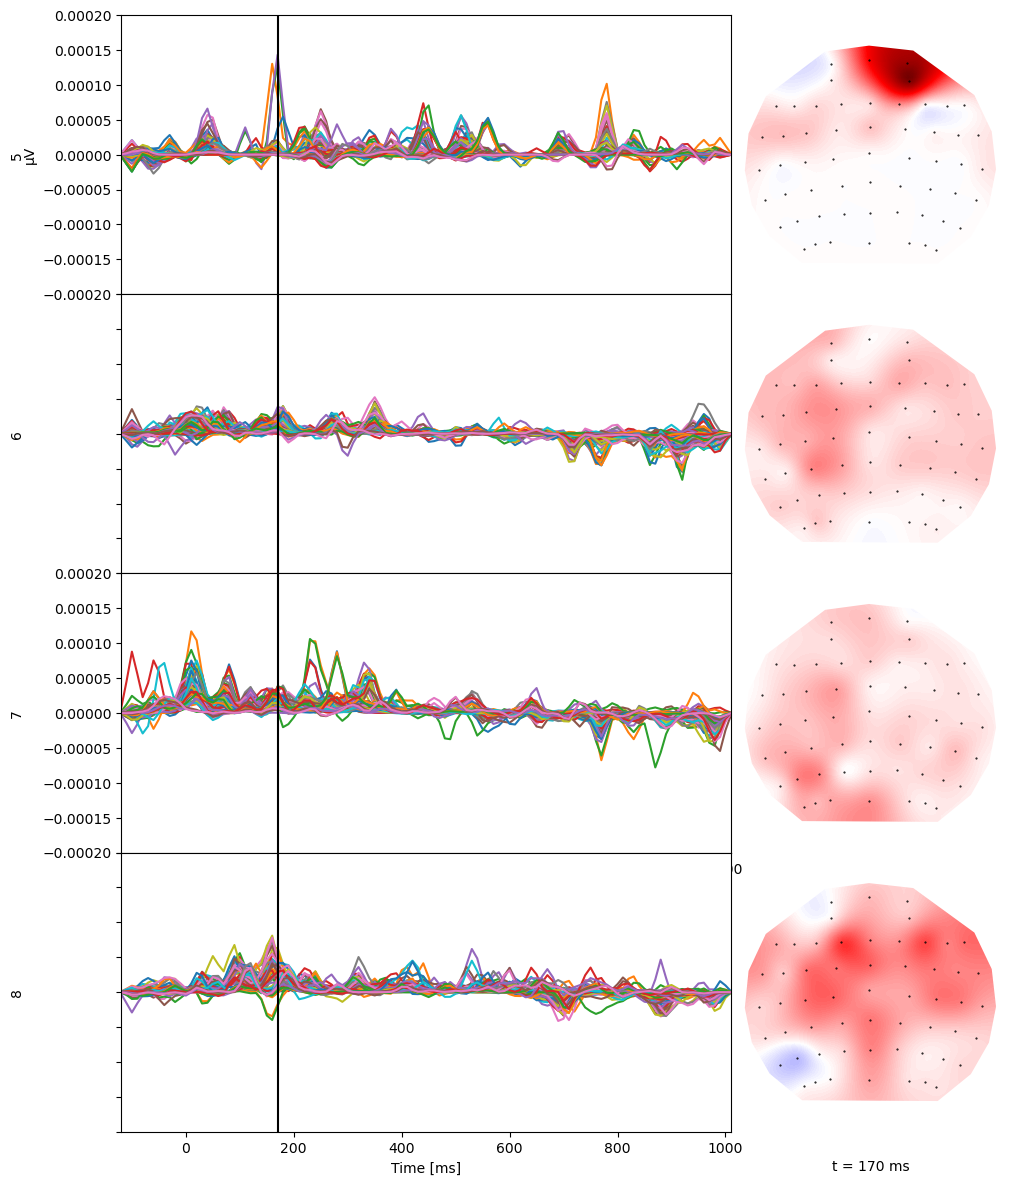

In [246]:
VST_F0_p = plot.TopoButterfly('Fzero', 'VST', data=n_trfs, t=0.17) #, axh=2, w=6)
VST_F0_p

In [196]:
print(type(n_trfs), n_trfs) #<class 'eelbrain._data_obj.Dataset'>
#print(type(n_rows), n_rows) # <class 'list'>
print(type(n_VST_trf_hscaledLIST), n_VST_trf_hscaledLIST) #<class 'list'> 

<class 'eelbrain._data_obj.Dataset'> subject   model                      VST
----------------------------------------
30        Fzero+envelope+env_onset   7  
27        Fzero+envelope+env_onset   8  
23        Fzero+envelope+env_onset   5.1
34        Fzero+envelope+env_onset   7.2
24        Fzero+envelope+env_onset   6.1
19        Fzero+envelope+env_onset   6.7
20        Fzero+envelope+env_onset   5.2
13        Fzero+envelope+env_onset   8.2
17        Fzero+envelope+env_onset   7.5
39        Fzero+envelope+env_onset   7.7
10        Fzero+envelope+env_onset   6.7
29        Fzero+envelope+env_onset   6.4
15        Fzero+envelope+env_onset   8.4
28        Fzero+envelope+env_onset   8.8
11        Fzero+envelope+env_onset   7.3
38        Fzero+envelope+env_onset   7.3
16        Fzero+envelope+env_onset   6.4
12        Fzero+envelope+env_onset   7.8
21        Fzero+envelope+env_onset   5.3
36        Fzero+envelope+env_onset   7.3
32        Fzero+envelope+env_onset   6.6
25        Fzero+enve

In [217]:
## USE Pure Correlation for F0 & VST >> Don't think this is the stats ##
#import eelbrain as eb

# Compute the correlation between the TRF data and VST scores.
corr_V0_VST_result = eelbrain.testnd.Correlation("Fzero", "VST", data=n_trfs)
corr_V0_VST_result_clus = corr_V0_VST_result.find_clusters(0.05)

print(corr_V0_VST_result)
print(corr_V0_VST_result_clus)

F0_VST_pic = corr_V0_VST_result.plot.TopoArray(corr_V0_VST_result)
F0_VST_pic.plot_colorbar(width=0.1)

# Plot the correlation timeline.
#corr_V0_VST_result.plot.TopoArray(title="Correlation (r) Timeline between TRF and VST")


Permutation test:   0%|          | 0/10000 [00:00<?, ? permutations/s]

<Correlation 'Fzero', 'VST', samples=10000, p = .096>
id   n_sensors   tstart   tstop   duration   p   sig
----------------------------------------------------


AttributeError: 'Correlation' object has no attribute 'plot'

In [170]:
for sub_ in n_trfs:
    print(type(sub_), len(sub_), sub_)

<class 'str'> 7 subject
<class 'str'> 5 model
<class 'str'> 3 VST
<class 'str'> 5 Fzero
<class 'str'> 8 envelope
<class 'str'> 5 onset


In [220]:
## Step 1: Gather Your Data
F0_all_LIST = []
subject_namesLIST = []
VST_all_LIST = []
for sub_ in n_rows:
    #print(type(sub_[0]), sub_[0])
    #print(type(sub_[3]), sub_[3])
    sub_VST = sub_[2]
    sub_F0 = sub_[3] #.get_data()
    #sub_env = sub_[4]
    #sub_envOn = sub_[5]
    #print(sub_[0], sub_F0, sub_VST)
    #print(sub_F0.name)  # dims = (<Sensor n=57, name=None>, UTS(-0.12000000000000001, 0.01, 114))
    # Create a list of subject names (e.g., "sub1", "sub2", ..., "sub26")
    subject_namesLIST.append(f"sub{sub_[0]}") #subject_names = [f"sub{i+1}" for i in range(n_subjects)]

    VST_all_LIST.append(sub_VST)
    
    #F0data = sub_F0.x
    #print(F0data.shape)
    #print(sub_F0.get_dims)
    
    F0_all_LIST.append(sub_F0)


# Now, build a Dataset with one column for subjects and one for the NDVar (sensor*time data)
F0_VST_ds = eelbrain.Dataset({
    "subject": subject_namesLIST,
    "data": F0_all_LIST,  # This column holds the NDVar for each subject
    "VST": VST_all_LIST
})

# Check the Dataset structure
print(F0_VST_ds)

subject   data              VST
-------------------------------
'sub30'   <NDVar 'Fzer...   7.0
'sub27'   <NDVar 'Fzer...   8.0
'sub23'   <NDVar 'Fzer...   5.1
'sub34'   <NDVar 'Fzer...   7.2
'sub24'   <NDVar 'Fzer...   6.1
'sub19'   <NDVar 'Fzer...   6.7
'sub20'   <NDVar 'Fzer...   5.2
'sub13'   <NDVar 'Fzer...   8.2
'sub17'   <NDVar 'Fzer...   7.5
'sub39'   <NDVar 'Fzer...   7.7
'sub10'   <NDVar 'Fzer...   6.7
'sub29'   <NDVar 'Fzer...   6.4
'sub15'   <NDVar 'Fzer...   8.4
'sub28'   <NDVar 'Fzer...   8.8
'sub11'   <NDVar 'Fzer...   7.3
'sub38'   <NDVar 'Fzer...   7.3
'sub16'   <NDVar 'Fzer...   6.4
'sub12'   <NDVar 'Fzer...   7.8
'sub21'   <NDVar 'Fzer...   5.3
'sub36'   <NDVar 'Fzer...   7.3
'sub32'   <NDVar 'Fzer...   6.6
'sub25'   <NDVar 'Fzer...   7.9
'sub35'   <NDVar 'Fzer...   7.0
'sub22'   <NDVar 'Fzer...   6.5
'sub26'   <NDVar 'Fzer...   8.7
'sub31'   <NDVar 'Fzer...   7.4


In [228]:

lms = []

# Loop over each subject in your dataset.
# F0_VST_ds['subject'] should be a list (or array) of subject names.
for sub in F0_VST_ds['subject']:
    # Extract the sub-dataset corresponding to this subject.
    ds_sub = F0_VST_ds.sub(subject=sub)
    
    # Fit the LM for this subject. The formula "data ~ VST" uses the NDVar in column "data"
    # as the response, and the VST value as the predictor.
    lm = eb.testnd.LM("data ~ VST", data=ds_sub, samples=0, subject=sub)
    
    # Save the model for later inspection.
    lms.append(lm)
    print(f"LM for subject {sub}:")
    print(lm)

TypeError: Dataset.sub() got an unexpected keyword argument 'subject'

In [224]:
## Using LM 
lms = []
#for subject in range(10):
for sub_ in F0_VST_ds["data"]:
    # generate data for one subject
    #ds = datasets.simulate_erp(seed=subject)
    # Re-reference EEG data
    #ds['eeg'] -= ds['eeg'].mean(sensor=['M1', 'M2'])
    print(type(sub_), sub_, sub_.sensor)
    # Fit stage 1 model (samples=0 because we do not need permutations at stage 1)
    #lm = testnd.LM('eeg', 'n_chars + cloze', data=ds, samples=0, subject=str(subject))
    #lms.append(lm)

<class 'eelbrain._data_obj.NDVar'> <NDVar 'Fzero': 57 sensor, 114 time> <Sensor n=57, name=None>
<class 'eelbrain._data_obj.NDVar'> <NDVar 'Fzero': 57 sensor, 114 time> <Sensor n=57, name=None>
<class 'eelbrain._data_obj.NDVar'> <NDVar 'Fzero': 57 sensor, 114 time> <Sensor n=57, name=None>
<class 'eelbrain._data_obj.NDVar'> <NDVar 'Fzero': 57 sensor, 114 time> <Sensor n=57, name=None>
<class 'eelbrain._data_obj.NDVar'> <NDVar 'Fzero': 57 sensor, 114 time> <Sensor n=57, name=None>
<class 'eelbrain._data_obj.NDVar'> <NDVar 'Fzero': 57 sensor, 114 time> <Sensor n=57, name=None>
<class 'eelbrain._data_obj.NDVar'> <NDVar 'Fzero': 57 sensor, 114 time> <Sensor n=57, name=None>
<class 'eelbrain._data_obj.NDVar'> <NDVar 'Fzero': 57 sensor, 114 time> <Sensor n=57, name=None>
<class 'eelbrain._data_obj.NDVar'> <NDVar 'Fzero': 57 sensor, 114 time> <Sensor n=57, name=None>
<class 'eelbrain._data_obj.NDVar'> <NDVar 'Fzero': 57 sensor, 114 time> <Sensor n=57, name=None>
<class 'eelbrain._data_obj.NDV

In [213]:
# Trying to plot the graph in subject * times 

## Step 1: Gather Your Data
F0_all_LIST = []
subject_namesLIST = []
VST_all_LIST = []
for sub_ in n_rows:
    #print(type(sub_[0]), sub_[0])
    #print(type(sub_[3]), sub_[3])
    sub_VST = sub_[2]
    sub_F0 = sub_[3] #.get_data()
    #sub_env = sub_[4]
    #sub_envOn = sub_[5]
    #print(sub_[0], sub_F0, sub_VST)
    #print(sub_F0.name)  # dims = (<Sensor n=57, name=None>, UTS(-0.12000000000000001, 0.01, 114))
    # Create a list of subject names (e.g., "sub1", "sub2", ..., "sub26")
    subject_namesLIST.append(f"sub{sub_[0]}") #subject_names = [f"sub{i+1}" for i in range(n_subjects)]

    VST_all_LIST.append(sub_VST)
    
    F0data = sub_F0.x
    #print(F0data.shape)
    print(sub_F0.get_dims)
    
    F0_all_LIST.append(F0data)

# get the sub * sensor * time ## 26*57*114
F0_3D_Array = np.stack(F0_all_LIST, axis=0)
#print(F0_3D_Array)


print(len(VST_all_LIST))

## Step 2: Compute Correlation for Each Sensor at Each Time ##
# create the vst into sub*VST_score
VST_array = np.array(VST_all_LIST)
#print(VST_array.shape, VST_array)

n_subjects, n_sensors, n_timepoints = F0_3D_Array.shape
r_vals = np.zeros((n_sensors, n_timepoints))
p_vals = np.zeros((n_sensors, n_timepoints))

for ch in range(n_sensors):      # For each sensor
    for t in range(n_timepoints):  # For each time point
        # This extracts the vector from all subjects for sensor ch at time t
        values = F0_3D_Array[:, ch, t]
        r, p = pearsonr(values, VST_array)  # Compute correlation (r) and p-value (p)
        r_vals[ch, t] = r
        p_vals[ch, t] = p

print(">>> r_vals")
print(type(r_vals))

print(">>> p_vals")
print(type(p_vals))

## Step 3: Clean Up the Results with FDR Correction ##
#from statsmodels.stats.multitest import multipletests

p_vals_flat = p_vals.flatten()
rej_flat, pvals_corrected, _, _ = multipletests(p_vals_flat, alpha=0.05, method='fdr_bh')
rej = rej_flat.reshape(n_sensors, n_timepoints)  # Now rej is a grid of True/False values

print(rej)
"""
## 4A. Butterfly Plot (All Sensors Overlaid)
#import matplotlib.pyplot as plt

time = np.linspace(0, 1, n_timepoints)  # Suppose time is from 0 to 1 second

plt.figure(figsize=(8, 5))
for ch in range(n_sensors):
    plt.plot(time, r_vals[ch, :], color='gray', alpha=0.5)  # color='gray'
plt.xlabel('Time (s)')
plt.ylabel('Correlation coefficient (r)')
plt.title('Butterfly Plot: All Sensor Correlation Timelines')
plt.grid(True)
plt.show()
"""
"""
## 4B. Topographic Array (Small Multiples for Each Sensor)
n_cols = 8  # How many plots per row
n_rows = int(np.ceil(n_sensors / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 12), sharex=True, sharey=True)
axs = axs.flatten()  # Make it easier to loop through
for ch in range(n_sensors):
    ax = axs[ch]
    ax.plot(time, r_vals[ch, :], color='blue')
    # Mark significant time points with red dots:
    sig_times = time[rej[ch, :]]
    sig_r = r_vals[ch, :][rej[ch, :]]
    ax.scatter(sig_times, sig_r, color='red', s=10)
    ax.set_title(f'Sensor {ch}')
    ax.set_ylim(-1, 1)
    ax.grid(True)
    
# Turn off any extra subplots if there aren't enough sensors
for i in range(n_sensors, len(axs)):
    axs[i].axis('off')

fig.suptitle('Topographic Array: Each Sensor\'s r Timeline (red dots = FDR-significant)', fontsize=16)
plt.xlabel('Time (s)')
plt.ylabel('Correlation (r)')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
"""



"""
# Now, build a Dataset with one column for subjects and one for the NDVar (sensor*time data)
ds = eelbrain.Dataset({
    "subject": subject_namesLIST,
    "data": F0_all_LIST,  # This column holds the NDVar for each subject
    "VST": VST_all_LIST
})

# Check the Dataset structure
print(ds)


print(len(F0_all_LIST))
F0_all_NDVar = eelbrain.concatenate(F0_all_LIST, dim=)
F0_all_pic = plot.TopoArray(F0_all_NDVar, t=[0.1, 0.2, 0.3], title="ESLs F0")
F0_all_pic.save(DST / Path("SUB_ALL_F0"))

F0_all_pic_butter = plot.TopoButterfly(F0_all_NDVar, t=0.1)
F0_all_pic_butter.save(DST / Path("SUB_ALL_F0_Butterfly"))
print(eelbrain.concatenate(F0_lm_LIST))
#print(type(NDVar(F0_lm_LIST,2)))
"""

<bound method NDVar.get_dims of <NDVar 'Fzero': 57 sensor, 114 time>>
<bound method NDVar.get_dims of <NDVar 'Fzero': 57 sensor, 114 time>>
<bound method NDVar.get_dims of <NDVar 'Fzero': 57 sensor, 114 time>>
<bound method NDVar.get_dims of <NDVar 'Fzero': 57 sensor, 114 time>>
<bound method NDVar.get_dims of <NDVar 'Fzero': 57 sensor, 114 time>>
<bound method NDVar.get_dims of <NDVar 'Fzero': 57 sensor, 114 time>>
<bound method NDVar.get_dims of <NDVar 'Fzero': 57 sensor, 114 time>>
<bound method NDVar.get_dims of <NDVar 'Fzero': 57 sensor, 114 time>>
<bound method NDVar.get_dims of <NDVar 'Fzero': 57 sensor, 114 time>>
<bound method NDVar.get_dims of <NDVar 'Fzero': 57 sensor, 114 time>>
<bound method NDVar.get_dims of <NDVar 'Fzero': 57 sensor, 114 time>>
<bound method NDVar.get_dims of <NDVar 'Fzero': 57 sensor, 114 time>>
<bound method NDVar.get_dims of <NDVar 'Fzero': 57 sensor, 114 time>>
<bound method NDVar.get_dims of <NDVar 'Fzero': 57 sensor, 114 time>>
<bound method NDVar.

'\n# Now, build a Dataset with one column for subjects and one for the NDVar (sensor*time data)\nds = eelbrain.Dataset({\n    "subject": subject_namesLIST,\n    "data": F0_all_LIST,  # This column holds the NDVar for each subject\n    "VST": VST_all_LIST\n})\n\n# Check the Dataset structure\nprint(ds)\n\n\nprint(len(F0_all_LIST))\nF0_all_NDVar = eelbrain.concatenate(F0_all_LIST, dim=)\nF0_all_pic = plot.TopoArray(F0_all_NDVar, t=[0.1, 0.2, 0.3], title="ESLs F0")\nF0_all_pic.save(DST / Path("SUB_ALL_F0"))\n\nF0_all_pic_butter = plot.TopoButterfly(F0_all_NDVar, t=0.1)\nF0_all_pic_butter.save(DST / Path("SUB_ALL_F0_Butterfly"))\nprint(eelbrain.concatenate(F0_lm_LIST))\n#print(type(NDVar(F0_lm_LIST,2)))\n'

In [211]:
print(F0_3D_Array.shape[1])
print(F0_3D_Array[0].get_dims)

57


AttributeError: 'numpy.ndarray' object has no attribute 'get_dims'

In [209]:
## Step 1: Create the NDVar (if not already done) ##
#import eelbrain as eb
#import numpy as np

n_sensors = F0_3D_Array.shape[1]
n_timepoints = F0_3D_Array.shape[2]

# Create sensor and time dimensions.
sensor_dim = eelbrain.Categorial("sensor", [str(i) for i in range(n_sensors)]) #, list(range(n_sensors)))
time_dim = eelbrain.UTS(-0.12000000000000001, 0.01, 114) #Range("time", 0, 1, n_timepoints)

# Suppose r_vals is already computed and is a NumPy array of shape (57, 114).
# Wrap the r_vals array into an NDVar.
r_ndvar = eelbrain.NDVar(r_vals, dims=[sensor_dim, time_dim])


## Step 2: Use Eelbrain’s TopoButterfly Function ##
#import matplotlib.pyplot as plt

# Set a colorful colormap (e.g., "viridis") so that the sensor traces appear in different hues.
plt.set_cmap("viridis")

# Generate the topographic butterfly plot.
eelbrain.plot.TopoButterfly(r_ndvar, #, mask=rej, mask_type='hatch'
                  title="TopoButterfly: All Sensor r Timelines with FDR Significance")
plt.show()



AttributeError: 'Categorial' object has no attribute '_visible_sensors'

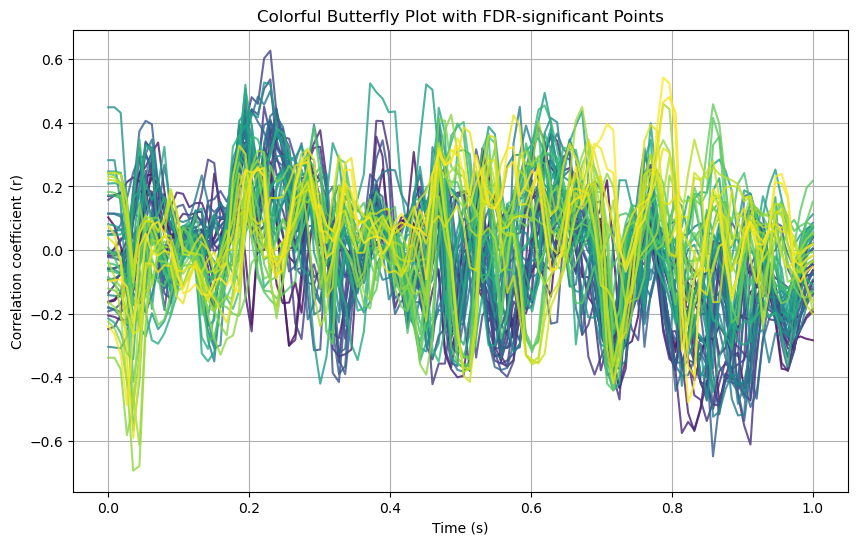

Sensor 0: Peak correlation at time = 0.903 s, r = -0.436
Sensor 1: Peak correlation at time = 0.965 s, r = -0.377
Sensor 2: Peak correlation at time = 0.221 s, r = 0.322
Sensor 3: Peak correlation at time = 0.867 s, r = -0.477
Sensor 4: Peak correlation at time = 0.717 s, r = -0.374
Sensor 5: Peak correlation at time = 0.832 s, r = -0.569
Sensor 6: Peak correlation at time = 0.814 s, r = -0.575
Sensor 7: Peak correlation at time = 0.850 s, r = -0.538
Sensor 8: Peak correlation at time = 0.912 s, r = -0.612
Sensor 9: Peak correlation at time = 0.221 s, r = 0.451
Sensor 10: Peak correlation at time = 0.850 s, r = -0.454
Sensor 11: Peak correlation at time = 0.230 s, r = 0.627
Sensor 12: Peak correlation at time = 0.230 s, r = 0.537
Sensor 13: Peak correlation at time = 0.186 s, r = 0.377
Sensor 14: Peak correlation at time = 0.195 s, r = 0.474
Sensor 15: Peak correlation at time = 0.867 s, r = -0.516
Sensor 16: Peak correlation at time = 0.858 s, r = -0.649
Sensor 17: Peak correlation at

'\n# A. Find the Peak for Each Sensor\n# Create arrays to store the peak time and peak r for each sensor.\npeak_time = np.zeros(n_sensors)\npeak_r   = np.zeros(n_sensors)\n\nfor ch in range(n_sensors):\n    # Find the index where the absolute correlation (ignoring sign) is maximum for this sensor.\n    peak_idx = np.argmax(np.abs(r_vals[ch, :]))\n    peak_time[ch] = time[peak_idx]\n    peak_r[ch]   = r_vals[ch, peak_idx]\n\n# Print the peak results for each sensor.\nfor ch in range(n_sensors):\n    print(f"Sensor {ch}: Peak time = {peak_time[ch]:.3f} s, Correlation r = {peak_r[ch]:.3f}")\n\n# B. Find the Overall Maximum Correlation Across All Sensors\n# Find the overall peak: the sensor/time pair with the maximum absolute correlation.\nmax_idx = np.unravel_index(np.argmax(np.abs(r_vals)), r_vals.shape)\nbest_sensor = max_idx[0]\nbest_time = time[max_idx[1]]\nbest_r = r_vals[best_sensor, max_idx[1]]\n\nprint(f"Overall best: Sensor {best_sensor} shows the strongest correlation of r = {be

In [187]:
## VERSION 1 ##
## Step 4: Apply FDR Correction and Overlay Significant Points ##
#from statsmodels.stats.multitest import multipletests

# Flatten the p_vals array (which is of shape (57, 114)) to perform FDR correction on all tests
p_vals_flat = p_vals.flatten()

# Apply FDR correction at alpha = 0.05 using the Benjamini-Hochberg method
rej_flat, pvals_corrected, _, _ = multipletests(p_vals_flat, alpha=0.05, method='fdr_bh')

# Reshape the rejection mask back to the original shape (57, 114)
rej = rej_flat.reshape(n_sensors, n_timepoints)

"""
# Now plot the colorful butterfly plot and overlay significant points with markers.
plt.figure(figsize=(10, 6))
for ch in range(n_sensors):
    # Plot the sensor's correlation timeline in its unique color.
    plt.plot(time, r_vals[ch, :], alpha=0.8) #, color=colors[ch]
    # Determine where FDR indicates significance for this sensor.
    sig_mask = rej[ch, :]  # This is a Boolean array for this sensor.
    # Overlay significant points as red dots (with a black edge for visibility).
    plt.scatter(time[sig_mask], r_vals[ch, :][sig_mask], color='red', edgecolor='k', s=40)  # s controls marker size  #color=colors[ch]

plt.xlabel("Time (s)")
plt.ylabel("Correlation coefficient (r)")
plt.title("Colorful Butterfly Plot with FDR-significant Points")
plt.grid(True)
plt.show()

## Step 5: Identify the Peak Correlations ##

# A. Find the Peak for Each Sensor
# Create arrays to store the peak time and peak r for each sensor.
peak_time = np.zeros(n_sensors)
peak_r   = np.zeros(n_sensors)

for ch in range(n_sensors):
    # Find the index where the absolute correlation (ignoring sign) is maximum for this sensor.
    peak_idx = np.argmax(np.abs(r_vals[ch, :]))
    peak_time[ch] = time[peak_idx]
    peak_r[ch]   = r_vals[ch, peak_idx]

# Print the peak results for each sensor.
for ch in range(n_sensors):
    print(f"Sensor {ch}: Peak time = {peak_time[ch]:.3f} s, Correlation r = {peak_r[ch]:.3f}")

# B. Find the Overall Maximum Correlation Across All Sensors
# Find the overall peak: the sensor/time pair with the maximum absolute correlation.
max_idx = np.unravel_index(np.argmax(np.abs(r_vals)), r_vals.shape)
best_sensor = max_idx[0]
best_time = time[max_idx[1]]
best_r = r_vals[best_sensor, max_idx[1]]

print(f"Overall best: Sensor {best_sensor} shows the strongest correlation of r = {best_r:.3f} at time {best_time:.3f} s.")
"""

## VERSION 2 ##
## Step B: Colorful Butterfly Plot with Significant Points Highlighted. ##
"""
#import matplotlib.pyplot as plt
# Suppose n_timepoints = 114, and define the time vector (e.g., 0-1 sec)
time = np.linspace(0, 1, n_timepoints)

# Get an array of colors – one for each sensor – from a colormap (here, 'viridis')
colors = plt.cm.viridis(np.linspace(0, 1, n_sensors))

plt.figure(figsize=(10, 6))
for ch in range(n_sensors):
    # Plot the r timeline for sensor 'ch' with its unique color
    plt.plot(time, r_vals[ch, :], color=colors[ch], alpha=0.8, label=f'Sensor {ch}' if ch < 10 else None)
    
    # Create a mask for significance in this sensor (True where significant)
    sig_mask = rej[ch, :]
    
    # Overlay significant points (you can choose marker style, here a larger circular marker)
    plt.scatter(time[sig_mask], r_vals[ch, :][sig_mask],
                color=colors[ch], edgecolor='k', s=40, zorder=3)  # zorder puts markers in front

plt.xlabel("Time (s)")
plt.ylabel("Correlation coefficient (r)")
plt.title("Colorful Butterfly Plot with FDR-significant Points")
plt.grid(True)
plt.show()
"""

## VERSION 3 ##
## 2. Colorful Butterfly Plot with Significant Points Overlaid ##
#import matplotlib.pyplot as plt

n_sensors = r_vals.shape[0]      # Should be 57
n_timepoints = r_vals.shape[1]   # Should be 114

# Create a time vector, e.g., from 0 to 1 second:
time = np.linspace(0, 1, n_timepoints)

# Choose a colormap (e.g., "viridis") to generate unique colors for each sensor.
colors = plt.cm.viridis(np.linspace(0, 1, n_sensors))

plt.figure(figsize=(10, 6))
for ch in range(n_sensors):
    # Plot the r timeline for each sensor with its unique color.
    plt.plot(time, r_vals[ch, :], color=colors[ch], alpha=0.8)
    
    # Identify significant time points for this sensor using the FDR mask.
    sig_indices = np.where(rej[ch, :])[0]
    
    # Overlay markers (scatter) on the significant points.
    plt.scatter(time[sig_indices], r_vals[ch, :][sig_indices],
                color=colors[ch], edgecolors='k', s=40, zorder=3)

plt.xlabel("Time (s)")
plt.ylabel("Correlation coefficient (r)")
plt.title("Colorful Butterfly Plot with FDR-significant Points")
plt.grid(True)
plt.show()

## 4. Extracting Peak Correlation (Outcome)
peak_time = np.zeros(n_sensors)
peak_r = np.zeros(n_sensors)

for ch in range(n_sensors):
    # Find the index of the maximum absolute correlation for this sensor.
    peak_idx = np.argmax(np.abs(r_vals[ch, :]))
    peak_time[ch] = time[peak_idx]
    peak_r[ch] = r_vals[ch, peak_idx]

# Print the peak results.
for ch in range(n_sensors):
    print(f"Sensor {ch}: Peak correlation at time = {peak_time[ch]:.3f} s, r = {peak_r[ch]:.3f}")

# Find the overall maximum absolute correlation across all sensors.
overall_peak_idx = np.unravel_index(np.argmax(np.abs(r_vals)), r_vals.shape)
best_sensor = overall_peak_idx[0]
best_time = time[overall_peak_idx[1]]
best_r = r_vals[best_sensor, overall_peak_idx[1]]
print(f"Overall highest: Sensor {best_sensor} with r = {best_r:.3f} at time = {best_time:.3f} s")

Sensor 0: Peak correlation at time = 0.903 s, r = -0.436
Sensor 1: Peak correlation at time = 0.965 s, r = -0.377
Sensor 2: Peak correlation at time = 0.221 s, r = 0.322
Sensor 3: Peak correlation at time = 0.867 s, r = -0.477
Sensor 4: Peak correlation at time = 0.717 s, r = -0.374
Sensor 5: Peak correlation at time = 0.832 s, r = -0.569
Sensor 6: Peak correlation at time = 0.814 s, r = -0.575
Sensor 7: Peak correlation at time = 0.850 s, r = -0.538
Sensor 8: Peak correlation at time = 0.912 s, r = -0.612
Sensor 9: Peak correlation at time = 0.221 s, r = 0.451
Sensor 10: Peak correlation at time = 0.850 s, r = -0.454
Sensor 11: Peak correlation at time = 0.230 s, r = 0.627
Sensor 12: Peak correlation at time = 0.230 s, r = 0.537
Sensor 13: Peak correlation at time = 0.186 s, r = 0.377
Sensor 14: Peak correlation at time = 0.195 s, r = 0.474
Sensor 15: Peak correlation at time = 0.867 s, r = -0.516
Sensor 16: Peak correlation at time = 0.858 s, r = -0.649
Sensor 17: Peak correlation at

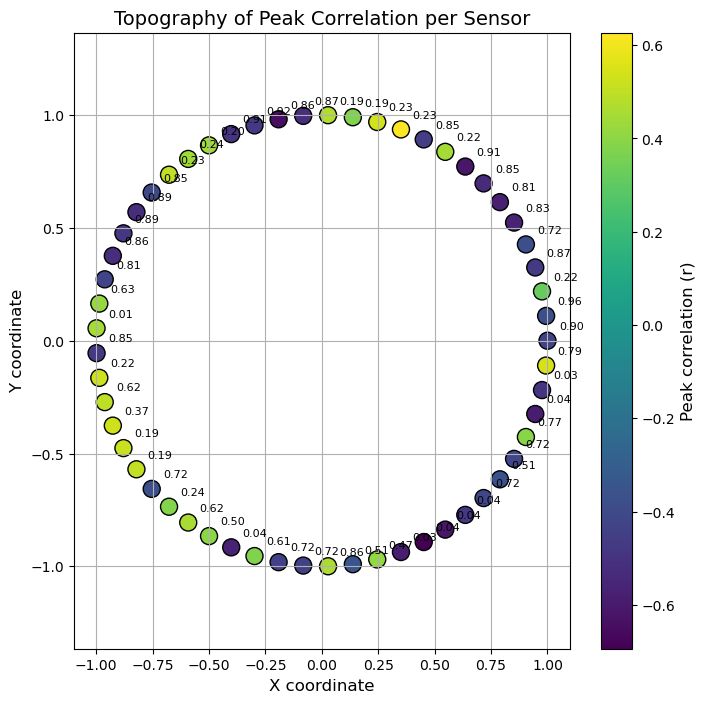

In [190]:
### GPT Prompt: How to plot the topography of this?? ###
## Step 1. Suppose You Already Have Your Peak Values ##

peak_time = np.zeros(n_sensors)
peak_r = np.zeros(n_sensors)

for ch in range(n_sensors):
    # Find the index of maximum absolute r for each sensor.
    peak_idx = np.argmax(np.abs(r_vals[ch, :]))
    peak_time[ch] = time[peak_idx]
    peak_r[ch] = r_vals[ch, peak_idx]

# Print results:
for ch in range(n_sensors):
    print(f"Sensor {ch}: Peak correlation at time = {peak_time[ch]:.3f} s, r = {peak_r[ch]:.3f}")

## Step 2. Generate (or Obtain) Sensor Coordinates ##
#import numpy as np

n_sensors = 57

# Simulate sensor positions on a circle:
angles = np.linspace(0, 2*np.pi, n_sensors, endpoint=False)
radius = 1.0  # You can adjust the radius if needed.
sensor_x = radius * np.cos(angles)
sensor_y = radius * np.sin(angles)

## Step 3. Plot the Topography Using Matplotlib ##
#import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

# Create a scatter plot: sensor positions colored by the peak r value.
sc = plt.scatter(sensor_x, sensor_y, c=peak_r, cmap='viridis', s=150, edgecolor='k')

# Add a colorbar to indicate the mapping of color to correlation magnitude.
cbar = plt.colorbar(sc)
cbar.set_label('Peak correlation (r)', fontsize=12)

# Optionally, annotate each sensor with its peak time value.
for i in range(n_sensors):
    plt.text(sensor_x[i]+0.05, sensor_y[i]+0.05, f"{peak_time[i]:.2f}", fontsize=8)

plt.title("Topography of Peak Correlation per Sensor", fontsize=14)
plt.xlabel("X coordinate", fontsize=12)
plt.ylabel("Y coordinate", fontsize=12)
plt.axis("equal")  # Ensure the aspect ratio is 1:1 for a proper head shape.
plt.grid(True)
plt.show()



In [191]:
## Example 1: Using an Existing Sensor Dimension

#import eelbrain as eb
#import matplotlib.pyplot as plt
#import numpy as np

# Suppose you have an NDVar 'r_ndvar' with shape (n_sensors, n_timepoints)
# where its sensor dimension has a layout, for example:
#    r_ndvar.dims   --> [sensor, time]

# And suppose you computed peak correlations per sensor already:
# peak_r: a NumPy array of shape (n_sensors,)
# peak_time: a NumPy array of shape (n_sensors,) (time of peak; may be shown as annotations)

# Extract the sensor dimension from your NDVar:
sensor_dim = r_ndvar.get_dim("sensor")  # This dimension may already have layout info

# Create a new NDVar for the peak correlations:
peak_r_ndvar = eb.NDVar(peak_r, dims=[sensor_dim])

# Now use Eelbrain’s topoplot function to plot the topography.
# This uses the sensor layout stored in sensor_dim.layout.
eb.topoplot(peak_r_ndvar, title="Topography of Peak Correlation (r)", colorbar=True)
plt.show()


NameError: name 'r_ndvar' is not defined

In [126]:
print(len(ds["data"][0]))

26


In [137]:
## Step 1. Create Dimension Objects for Group-Level NDVars ##
# Assuming 57 sensors and 114 time points.
n_sensors = len(ds["data"][0]) #57
n_timepoints = len(ds["data"][0][0]) # 114

# Create a sensor dimension with labels 0 through 56.
sensor_dim = eelbrain.Categorial("sensor", list(str(range(n_sensors))))

# Create a time dimension.
# Example: 114 time points from 0 to 1 second. Adjust the time range as needed.
time_points = np.linspace(0, 1, n_timepoints)
time_dim = eelbrain.UTS(0, 1, n_timepoints)
#time_dim = eelbrain.TimeDim(time_points)

## Step 2. Convert r_vals and p_vals Arrays to NDVar Objects ##


# (Assume data and vst are already defined)
r_vals = np.zeros((n_sensors, n_timepoints))
p_vals = np.zeros((n_sensors, n_timepoints))


for ch in range(n_sensors):      # For each sensor
    for t in range(n_timepoints):  # For each time point
        values = ds[:, ch, t]     # Get all subjects’ readings at sensor ch, time t
        r, p = pearsonr(values, vst)  # Compute correlation (r) and p-value (p)
        r_vals[ch, t] = r
        p_vals[ch, t] = p

# Assume r_vals and p_vals were computed as in your loop.
# r_vals and p_vals are both of shape (n_sensors, n_timepoints).
r_ndvar = eelbrain.NDVar(r_vals, dims=[sensor_dim, time_dim])
p_ndvar = eelbrain.NDVar(p_vals, dims=[sensor_dim, time_dim])

KeyError: 'Invalid index for Dataset: (slice(None, None, None), 0, 0)'

In [ ]:
### import eelbrain as eb
#import matplotlib.pyplot as plt
#import numpy as np

# --- Data Assumptions ---
# trf: an NDVar with the TRF for F0; dimensions: (subjects, time)
# ds: an Eelbrain Dataset with at least one column "VST" that holds vocabulary size test scores.
# (These objects should already be loaded/created)

# --- Run Multiple Regression ---
# The following code fits a linear model (LM) where the TRF is predicted by the VST score.
res_all_lm = eelbrain.testnd.LM('Fzero+envelope+onset', 'VST', data=n_trfs)#ds)
print(type(res_all_lm))
#res_all_LMGroup = eelbrain.testnd.LMGroup(res_all_lm)#ds)
#res_F0 = eelbrain.testnd.LM('Fzero', 'VST', data=n_trfs['Fzero'])#ds)
#res_all_LMGroup

In [51]:
sub_All_F0_Array = plot.TopoArray(n_rows, t=[0.13, 0.3], title="F0")
sub_All_F0_Array.save(DST / Path("SUB_ALL_F0_array"))

TypeError: NDVar required, got 30

In [20]:
"""
# --- Plot the Regression Coefficient (r timeline) ---
# This plots the effect (beta, which is equivalent to correlation if predictors are standardized) over time.
# The default plot method marks significant time points (if any) based on the internal threshold.
res['VST'].plot()
plt.title("Regression Coefficient (r) Timeline for VST")
plt.xlabel("Time (ms)")
plt.ylabel("Coefficient (r)")
plt.show()

"""
p_all_VST = eelbrain.plot.TopoArray(res_all_lm, t=[0.1, 0.42, 0.7], head_radius=0.35) #, t=[0.120, 0.155, None], title=result
p_cb_all = p_all_VST.plot_colorbar(right_of=p_all_VST.axes[0], label='t')
p_all_VST.save(DST / "sub%s_F0" %str(sub_[0]))

"""
p_F0_VST = eelbrain.plot.TopoArray(res_F0, head_radius=0.35) #, t=[0.120, 0.155, None], title=result
p_cb_F0 = p_F0_VST.plot_colorbar(right_of=p_F0_VST.axes[0], label='t')
p_F0_VST
"""

"\np_F0_VST = eelbrain.plot.TopoArray(res_F0, head_radius=0.35) #, t=[0.120, 0.155, None], title=result\np_cb_F0 = p_F0_VST.plot_colorbar(right_of=p_F0_VST.axes[0], label='t')\np_F0_VST\n"

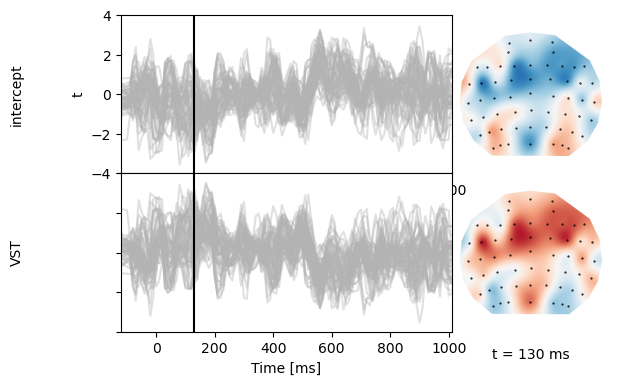

In [23]:
p_all_VST_butterfly = plot.TopoButterfly(res_all, t=0.130, axh=2, w=6)
p_all_VST_butterfly

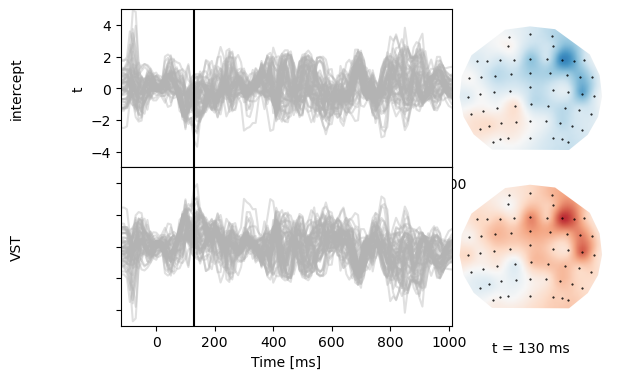

In [22]:
p_F0_VST_butterfly = plot.TopoButterfly(res_F0, t=0.130, axh=2, w=6)
p_F0_VST_butterfly

In [27]:
lm = testnd.LM(n_trfs['Fzero'], 'VST', data=n_trfs, samples=0) #, subject=str(subject))
pprint(lm)

<LM 'Fzero', 'VST', samples=0>


In [167]:
n_trfs = eelbrain.Dataset.from_caselist(['subject', 'model', "VST" ,*n_trf.x], n_rows)
print(n_trfs)
print(type(n_trfs))

subject   model                      VST
----------------------------------------
30        Fzero+envelope+env_onset   7  
27        Fzero+envelope+env_onset   8  
23        Fzero+envelope+env_onset   5.1
34        Fzero+envelope+env_onset   7.2
24        Fzero+envelope+env_onset   6.1
19        Fzero+envelope+env_onset   6.7
20        Fzero+envelope+env_onset   5.2
13        Fzero+envelope+env_onset   8.2
17        Fzero+envelope+env_onset   7.5
39        Fzero+envelope+env_onset   7.7
10        Fzero+envelope+env_onset   6.7
29        Fzero+envelope+env_onset   6.4
15        Fzero+envelope+env_onset   8.4
28        Fzero+envelope+env_onset   8.8
11        Fzero+envelope+env_onset   7.3
38        Fzero+envelope+env_onset   7.3
16        Fzero+envelope+env_onset   6.4
12        Fzero+envelope+env_onset   7.8
21        Fzero+envelope+env_onset   5.3
36        Fzero+envelope+env_onset   7.3
32        Fzero+envelope+env_onset   6.6
25        Fzero+envelope+env_onset   7.9
35        Fzero+

In [166]:
lmsLIST = []

for trf_subject in n_trfs:
    print(trf_subject['Fzero'])
    #print(trf_subject[3].x) # Fzero data
    #print(trf_subject[2]) # VST
    #n_rows.append([n_subj, model, VST_scoreFLOAT, *n_trf.h_scaled])
    #lm = testnd.LM(trf_subject[3], trf_subject[1], data=trf_subject, samples=0, subject=str(subject))
    #print(lm)
    #lms.append(lm)
#print(lmsLIST)

TypeError: string indices must be integers, not 'str'

In [135]:
# Basic regression: TRF ~ language_score
F0_VST_res = testnd.LM('Fzero', 'VST', data=n_trfs)
print(F0_VST_res)

Permutation test:   0%|          | 0/10000 [00:00<?, ? permutations/s]

<LM 'Fzero', 'VST', samples=10000, 'intercept': p = .114, 'VST': p = .096>


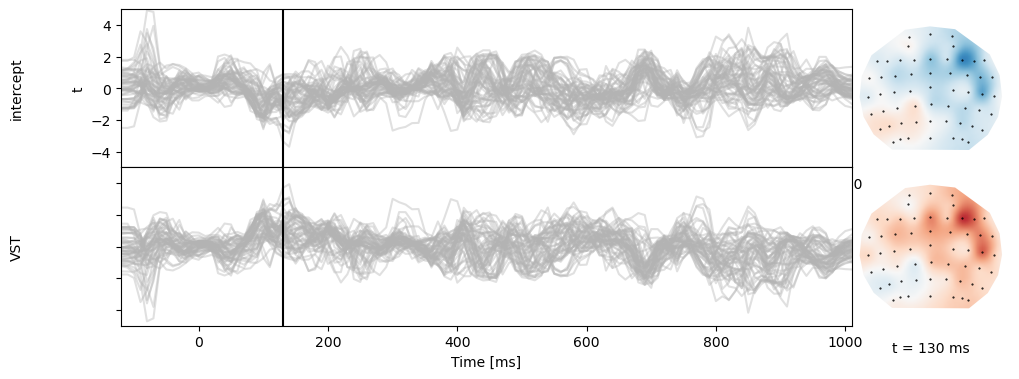

In [145]:
p_F0_VST = eelbrain.plot.TopoButterfly(F0_VST_res, t=0.130, axh=2, w=10)
#p_F0_bar = p_F0.plot_colorbar(label="F0", width=0.1)
p_F0_VST